# Task 3.1 - Introduction of Noise to Observed Dynamics

In [1]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [2]:
%matplotlib notebook

## Generate Training Data

In [3]:
N = 512 * 2

np.random.seed(4)

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get N initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20 ] )

pad0 = lambda p : np.pad( p, (0,1) )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action_RK4( pad0(state) )[:4] - state for state in initial_states ] )

## Scatter Plots

<IPython.core.display.Javascript object>


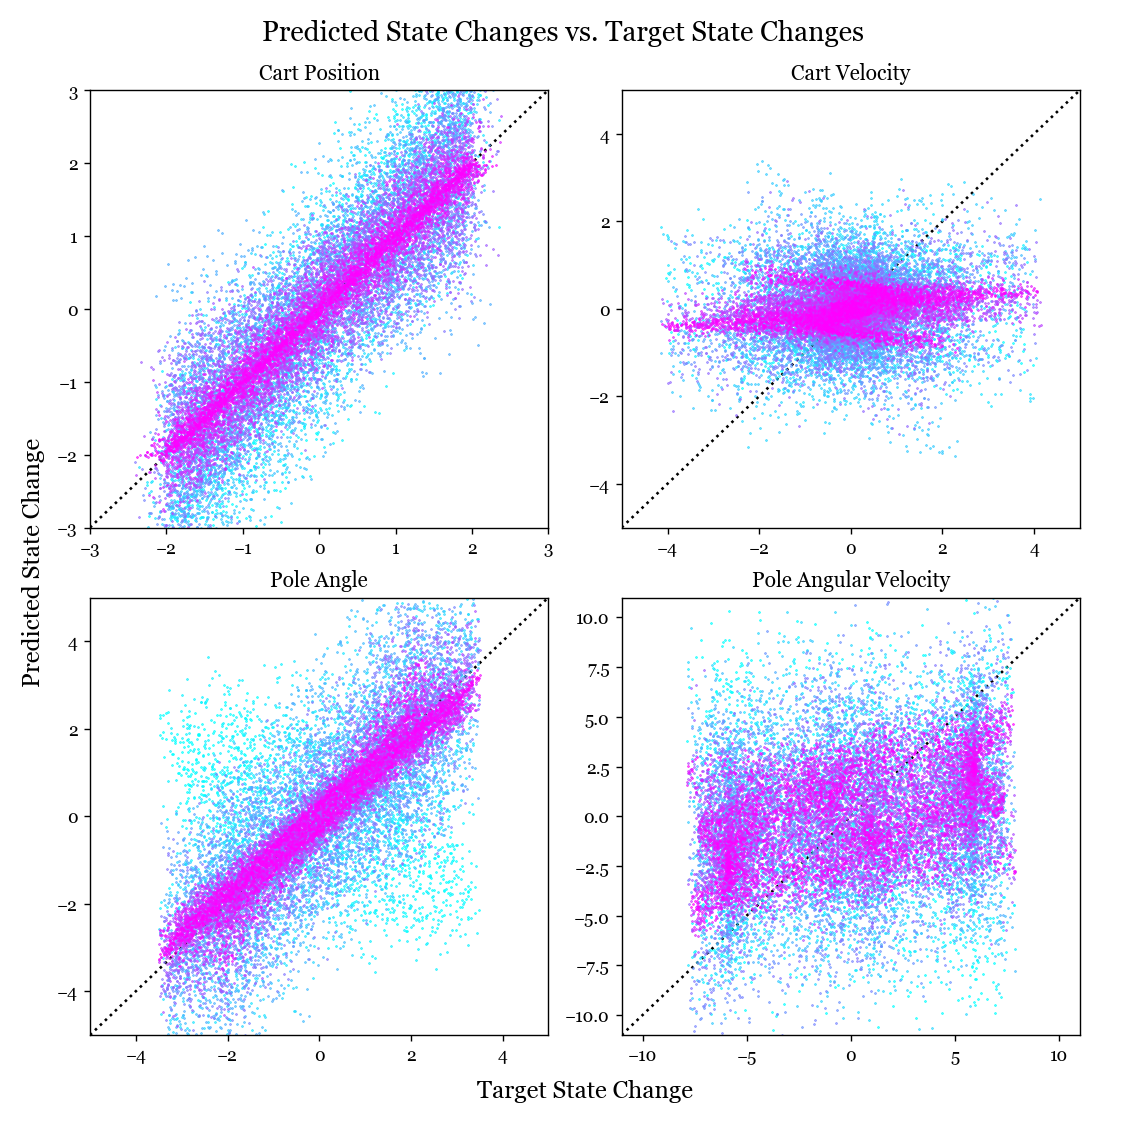

Text(0.03, 0.5, 'Predicted State Change')

In [44]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=19, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

colours = matplotlib.cm.get_cmap('cool')( np.linspace(0,1,20) )

extents = np.array([ 3, 5, 5, 11 ])

pad0 = lambda p : np.pad( p, (0,1) )


N = 512 * 2

np.random.seed(4)


for j in range(20):    
    
    # get N initial states spaced in the recommended ranges
    X = initial_states = ( np.random.rand( N, 4 ) - 0.5 ) * 2 * np.array( [ 10, 10, np.pi, 15 ] )

    # generate the changes in state from these states
    Y = np.array( [ CartPole.perform_action_RK4( pad0(state) )[:4] - state for state in initial_states ] )

    noise_level = (19-j) * 1.05
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * np.mean(np.abs(Y), axis=0)

    Xplus = np.linalg.inv(X.T @ X) @ X.T
    C = Xplus @ Yn

    XC = X @ C

    for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

        x, y = XC[:,i], Y[:,i]

        ax.scatter( y, x, s=0.2, color=colours[j], zorder=2 )
        
        if j > 0:
            continue

        extent = extents[i]
        
        ax.set_xlim(-extent, extent)
        ax.set_ylim(-extent, extent)

        ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )

        ax.set_title( titles[i] )
    
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

## Linear Model Accuracy with Varying Observation Noise

Above are scatter plots of the predicted state change against target state change for linear models fitted with varying amounts of observation noise. Magenta represents models fit with little noise, and cyan with a lot of noise added. The cart position and pole angle plots show improved prediction accuracy with less noise, as does the cart velocity plot although the linear model can't acheive a very good fit for this variable even with zero noise. The pole angular velocity plot shows bad predictions for all noise levels so I suppose is less sensitive to noise. Also note that I scaled the noise for each variable based on the average magnitude of the points in the plots to make the comparison more fair.

<IPython.core.display.Javascript object>


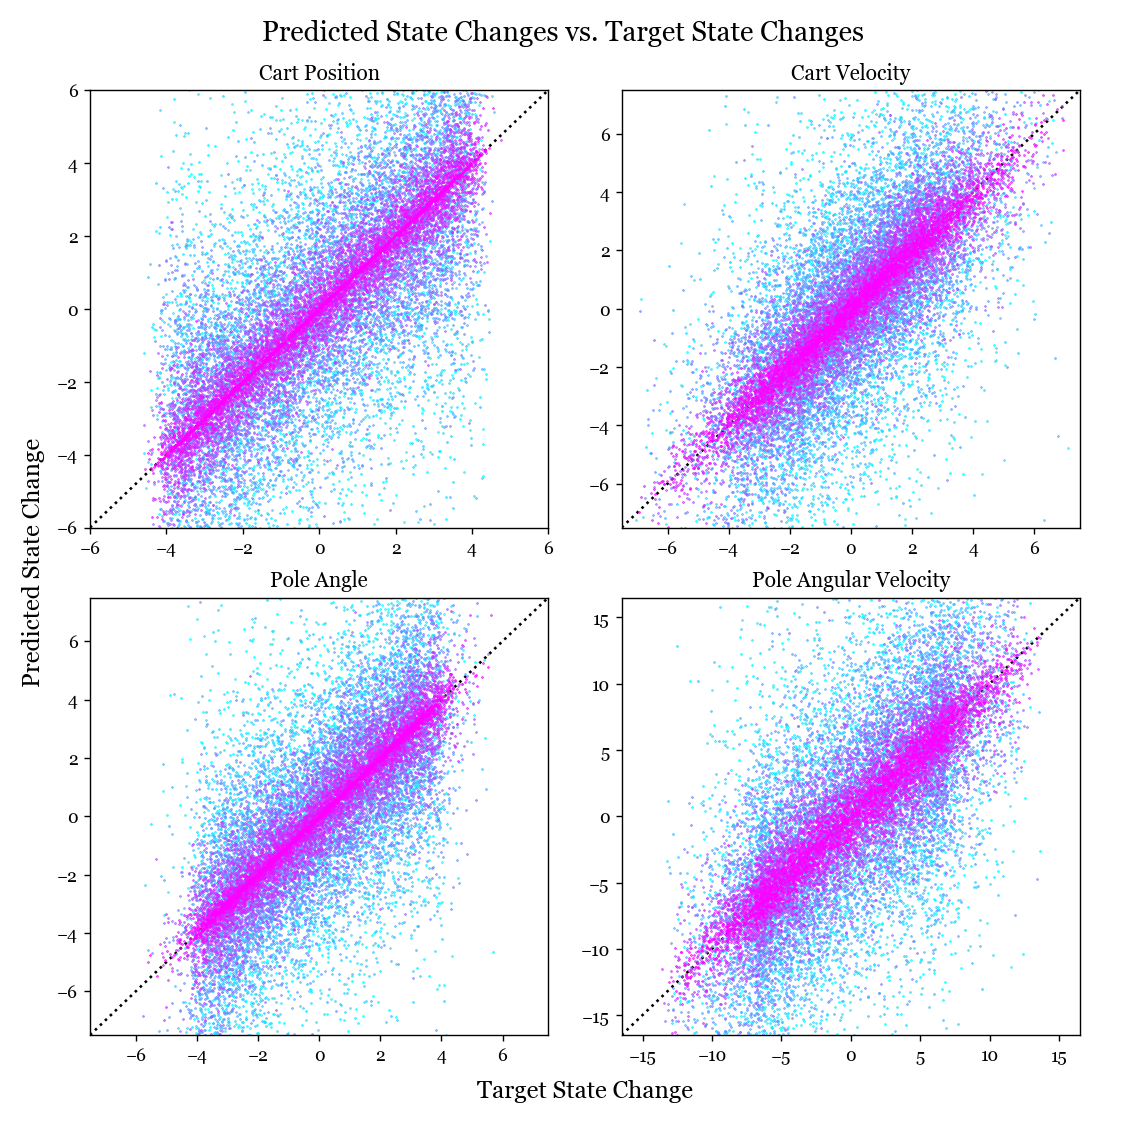

Text(0.03, 0.5, 'Predicted State Change')

In [6]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=21, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

colours = matplotlib.cm.get_cmap('cool')( np.linspace(0,1,20) )

extents = np.array([ 4, 5, 5, 11 ]) * 1.5

pad0 = lambda p : np.pad( p, (0,1) )

np.random.seed(4)


for j in range(20):    
    
    N = 512 * 8

    # set the random seed and create the sobol sequence generator
    sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=j )

    # get N initial states spaced in the recommended ranges
    X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

    # generate the changes in state from these states
    Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )

    
    noise_level = (19-j) * 0.25
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * np.mean(np.abs(Y), axis=0)    

    
    M = 32 * 32
    kernel_centres = X[:M]


    sigma = np.std( X, axis=0 )

    def K( X, Xp, sigma = sigma ):

        # get squared differences and substitute angle one for periodic version
        d2 = ( (X - Xp) / sigma ) ** 2
        d2[:,0] = 0
        d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2

        # divide rows by 2 sigma and return exponential of negative sum along rows
        return np.exp( - 0.5 * np.sum( d2, axis=1 ) )


    # loop over the kernel centres and evaluate the K function across all the Xs at each
    Kmn = np.zeros( (M,N) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmn[i] = K( X, kernel_centre[np.newaxis] )

    # same as above but only use first M vectors from X
    Kmm = np.zeros( (M,M) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


    l = 1e-4

    KmnKnm = Kmn @ Kmn.T
    a = KmnKnm + l * Kmm
    b = Kmn @ Yn

    alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

    
    predictions = Kmn.T @ alpha_m
    
    
    for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):

        x, y = predictions[:1024,i], Y[:1024,i]

        ax.scatter( y, x, s=0.2, color=colours[j], zorder=2 )
        
        if j > 0:
            continue

        extent = extents[i]
        
        ax.set_xlim(-extent, extent)
        ax.set_ylim(-extent, extent)

        ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )

        ax.set_title( titles[i] )
    
    
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

## Effect of Noise on the Nonlinear Model

Above is the same plot, but using the nonlinear model rather than the linear model. Again the low noise scenario in magenta shows better predictions than the cyan noisy scenario, but this time the zero noise predictions are much better. Interestingly the above plots have one quarter as much noise added as those using the linear model, but still show similar deviation from the ideal line. This indicates that the nonlinear model is more sensitive to noise. I think this makes sense - for a linear function, the noise on either side of the desired fit almost cancels out so that the desired fit is less affected. The nonlinear model is actually able to fit to the noise which means its predictions of the true dynamics are worse.

In [7]:

linear_errors = []
nonlinear_errors = []

for j in range(20):
    
    N = q512 * 8

    # set the random seed and create the sobol sequence generator
    sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=j )

    # get N initial states spaced in the recommended ranges
    X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

    # generate the changes in state from these states
    Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )

    
    noise_level = (19-j)
    
    Yn = Y + np.random.randn( *Y.shape ) * noise_level * np.mean(np.abs(Y), axis=0)    

    
    M = 32 * 32
    kernel_centres = X[:M]
    
    
    # linear fit
    
    Xl = X[:1024]
    Ynl = Yn[:1024]
    
    Xplus = np.linalg.inv(Xl.T @ Xl) @ Xl.T
    C = Xplus @ Ynl

    
    # nonlinear fit

    sigma = np.std( X, axis=0 )

    def K( X, Xp, sigma = sigma ):

        # get squared differences and substitute angle one for periodic version
        d2 = ( (X - Xp) / sigma ) ** 2
        d2[:,0] = 0
        d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2

        # divide rows by 2 sigma and return exponential of negative sum along rows
        return np.exp( - 0.5 * np.sum( d2, axis=1 ) )


    # loop over the kernel centres and evaluate the K function across all the Xs at each
    Kmn = np.zeros( (M,N) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmn[i] = K( X, kernel_centre[np.newaxis] )

    # same as above but only use first M vectors from X
    Kmm = np.zeros( (M,M) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


    l = 1e-4

    KmnKnm = Kmn @ Kmn.T
    a = KmnKnm + l * Kmm
    b = Kmn @ Yn

    alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]
    
    
    # get the predictions
    
    linear_predictions = X @ C
    nonlinear_predictions = Kmn.T @ alpha_m
    
    
    # evaluate the models
    
    linear_error    = np.sum( np.linalg.norm(    linear_predictions - Y, axis=1 ) )
    nonlinear_error = np.sum( np.linalg.norm( nonlinear_predictions - Y, axis=1 ) )
    
    linear_errors.append( linear_error )
    nonlinear_errors.append( nonlinear_error )

<IPython.core.display.Javascript object>


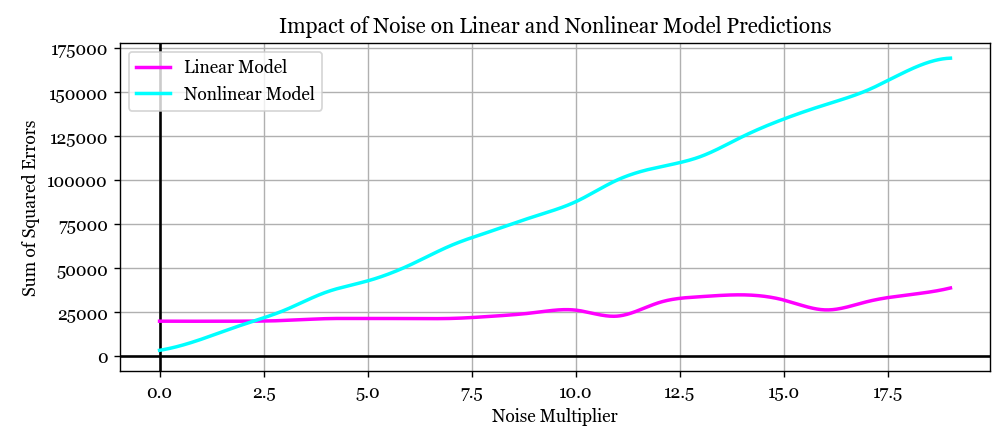

In [8]:
fig, ax = plt.subplots(1, 1, num=66, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.12, right=0.99)
sf3utility.setup_phase_portrait( ax )

j = np.arange( 20 )
x = noise_level = (19-j)

y1 = np.array( linear_errors )
y2 = np.array( nonlinear_errors )

f1 = scipy.interpolate.interp1d( x, y1, kind='cubic' )
f2 = scipy.interpolate.interp1d( x, y2, kind='cubic' )

xnew = np.linspace(x[0], x[-1], 800)

ax.plot( xnew, f1(xnew), color="magenta", label="Linear Model", linewidth=2 )
ax.plot( xnew, f2(xnew), color="cyan", label="Nonlinear Model", linewidth=2 )


ax.set_title( "Impact of Noise on Linear and Nonlinear Model Predictions" )
ax.set_xlabel( "Noise Multiplier" )
ax.set_ylabel( "Sum of Squared Errors" )
ax.legend(loc="upper left")

The above plot shows how the sum of squared errors varies with the noise level for the linear and nonlinear models. The linear model is more resistant to the noise, while the nonlinear model is linearly impacted by the noise although its initial squared error is lower. So there is a crossover point where the optimal model flips from the nonlinear one to the linear one - at least for this regularisation strength. This is an important point as it indicates the nonlinear model has overfit to the training data. The more parsimonious linear model performs better because its small number of parameters forces it to capture real overarching structure in the data rather than the noisy quirks that the nonlinear model's huge number of parameters can overfit to.

In [36]:
np.random.seed(4)

ls = np.logspace( -4, 3, num=20, base=2 )
noise_levels = np.linspace( 0, 5, num=20 )

errors = np.zeros( (20, 20) )

N = 512 * 2

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=4 )

# get N initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action_RK4( state ) - state for state in initial_states ] )


M = 32 * 16
kernel_centres = X[:M]


# nonlinear fit

sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):

    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2

    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )


# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):

    Kmn[i] = K( X, kernel_centre[np.newaxis] )

# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):

    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


KmnKnm = Kmn @ Kmn.T

randoms = np.random.randn( *Y.shape )
means = np.mean(np.abs(Y), axis=0)
pertubations = randoms * means


for j, noise_level in enumerate( noise_levels ):
    
    Yn = Y + pertubations * noise_level   
    b = Kmn @ Yn
        
        
    for i, l in enumerate(ls):

        a = KmnKnm + l * Kmm

        alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

        nonlinear_predictions = Kmn.T @ alpha_m

        # evaluate the models

        nonlinear_error = np.sum( np.linalg.norm( nonlinear_predictions - Y, axis=1 ) )    
        errors[i, j] = nonlinear_error
        

<IPython.core.display.Javascript object>


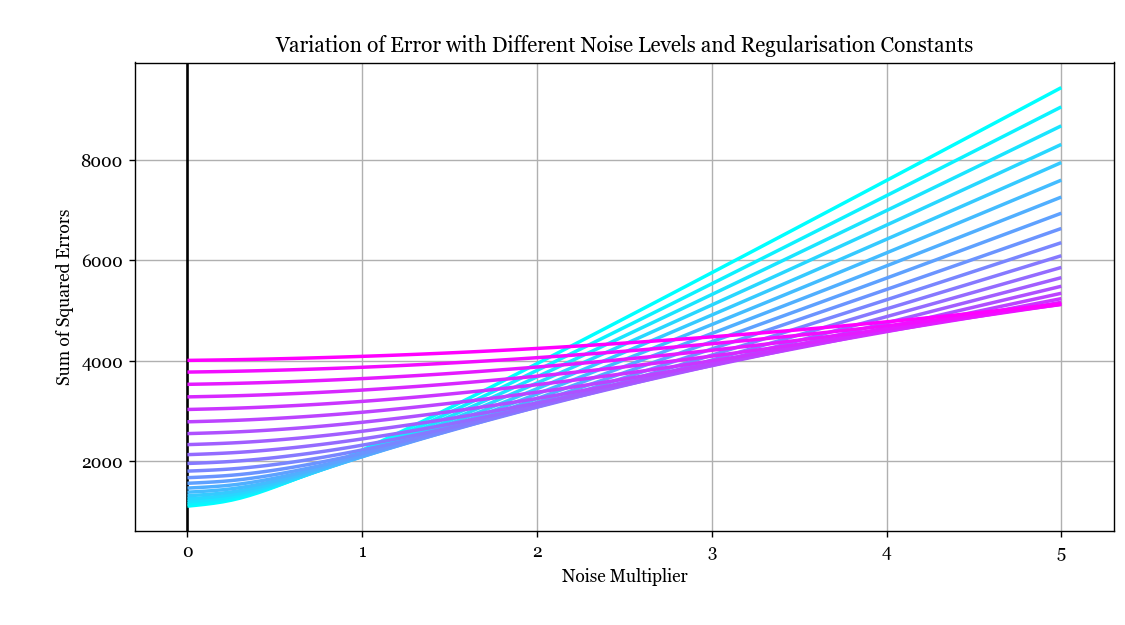

(598.3273929222096, 9948.458250454094)

In [37]:
fig, ax = plt.subplots(1, 1, num=12, figsize=(9,5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.12, right=0.99)
sf3utility.setup_phase_portrait( ax )

colours = matplotlib.cm.get_cmap('cool')( np.linspace(0,1,20) )

ls = np.logspace( -4, 3, num=20, base=2 )
noise_levels = np.linspace( 0, 5, num=20 )

xx = np.broadcast_to( noise_levels, (20, 20) )
yy = errors

interpolant = scipy.interpolate.make_interp_spline( noise_levels, yy, axis=1, bc_type="natural" )

xxint = np.linspace( min(noise_levels), max(noise_levels), num=100 )
yyint = interpolant( xxint )
xxint = np.broadcast_to( xxint, (20, 100) )

segments = np.stack( (xxint, yyint), axis=2 )

linecollection = matplotlib.collections.LineCollection( segments, colors=colours, linewidths=2 )

ax.add_collection( linecollection )

ax.set_title( "Variation of Error with Different Noise Levels and Regularisation Constants" )
ax.set_xlabel( "Noise Multiplier" )
ax.set_ylabel( "Sum of Squared Errors" )

centerx = (np.max(xx) + np.min(xx)) / 2
centery = (np.max(yy) + np.min(yy)) / 2

ax.set_xlim( centerx - (centerx - np.min(xx)) * 1.12, centerx + (np.max(xx) - centerx) * 1.12 )
ax.set_ylim( centery - (centery - np.min(yy)) * 1.12, centery + (np.max(yy) - centery) * 1.12 )


## Error vs Noise Level and Regularisation

Above I have plotted the sum of squared errors against varying observation noise level for the nonlinear model, where each line has a different regularisation constant. The regularisation constants vary logarithmically from $2^{-4}$ in cyan to $2^{3}$ in magenta. As indicated by the gradient along the locus of the lowest points of the curves, the lowest line on the graph depends on the noise level - in other words, the optimal regularisation constant increases as the noise level increases. This cements the regularisation constant as a hyperparameter that helps to avoid overfitting. We also know from Gaussian Process theory that the regularisation constant is the variance of the noise, so this matches up well.

## Stability of Linear Policy



<IPython.core.display.Javascript object>


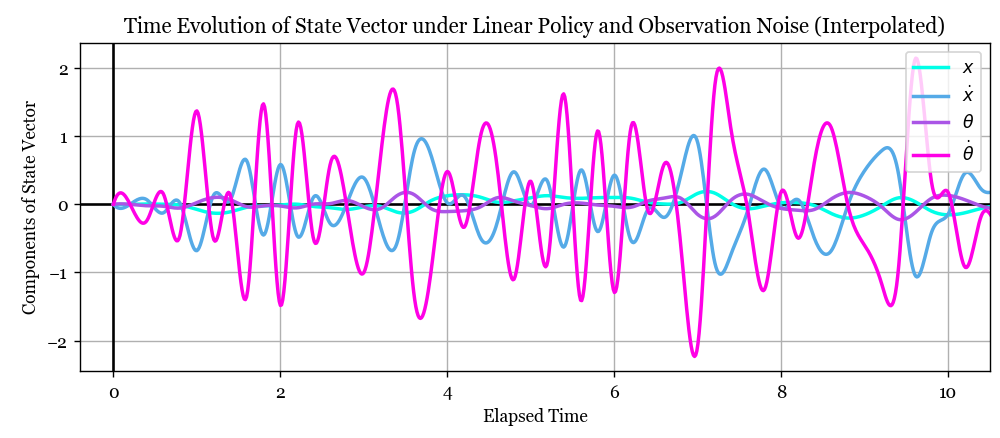

(-0.4, 10.5)

In [20]:
fig, ax = plt.subplots(1, 1, num=33, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

state = np.array( [ 0, 0, 0, 0, 0 ] )

noise_level = 0.01

states = []
times = []

np.random.seed(4)

for i in range(55):
    
    states.append( state )
    times.append( i * 0.2 )
    
    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )
    clipped_state = clipped_state + np.random.randn( 5 ) * means * noise_level

    state[4] = p @ clipped_state
    state = CartPole.perform_action_RK4( state )

states = np.array( states )
times = np.array( times )

x = times
y = states

col_lerp = np.linspace(0, 1, 4)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255

labels = ["$x$","$\dot{x}$","$θ$","$\dot{θ}$"]

for i in range(4):
    
    f2 = scipy.interpolate.interp1d(x, y[:,i], kind='cubic')

    xnew = np.linspace(0, times[-1], 800)
    
    ax.plot( xnew, f2(xnew), color=colours[i], label=labels[i], linewidth=2 )

ax.set_title( "Time Evolution of State Vector under Linear Policy and Observation Noise (Interpolated)" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Components of State Vector" )
ax.legend(loc="upper right")

# ax.set_ylim( -5, 5 )
ax.set_xlim( -0.4, 10.5 )

## Linear Policy with Noise

Above I have plotted a typical time evolution for the state vector under the linear policy with observation noise added. The policy is just about able to prevent the system from losing control at this noise level, so the states all fluctuate around 0.

In [11]:
def noisy_rollout_loss( initial_state, p ):
    
    state = initial_state
    sim_seconds = 8
    sim_steps = int( sim_seconds / 0.2 )
    loss = 0
    noise_level = 0.01
    
    for i in range( sim_steps ):
        
        if np.any( np.abs(state) > np.array([10,40,50,1e+3,1e+3]) ):
            return sim_steps
        
        
        noisy_state = state + np.random.randn( 5 ) * means * noise_level
        
        state[4] = p @ noisy_state
        loss += CartPole.loss( state[:4] )
        state = CartPole.perform_action_RK4( state )
    
    return loss

In [12]:
# %%time

# # initial_state = np.array( [ 0.2, 0, 0.2, 0, 0 ] )
# initial_state = np.array( [ 0.0, 0, 0, 0, 0 ] ) # larger initial state for better generality
# #initial_state = np.array( [1,0,0.5,0,0] )

# pad0 = lambda p : np.pad( p, (0,1) )
# model_rollout_loss_from_initial = lambda p : noisy_rollout_loss( initial_state, pad0(p) )

# min_loss = 999999
# best_p = None

# for i in range(100):

#     p0     = np.array( [0.75971638,  1.44284499, 17.05744679,  2.66183469] ) + np.random.rand( 4 ) * 3 - 1.5
#     result = scipy.optimize.minimize( model_rollout_loss_from_initial, p0, method="Nelder-Mead" )
    
#     end_loss = result["fun"]
    
#     if end_loss < min_loss:
#         best_p = result["x"]
#         min_loss = end_loss
        
#     print(best_p, min_loss)
    
# p = pad0(best_p)

[-0.52521995  2.53259879 17.59080735  2.03993897] 40.0
[ 1.50276907  0.06796849 15.87015006  1.30006876] 19.012453484900025
[ 1.50276907  0.06796849 15.87015006  1.30006876] 19.012453484900025
[ 1.50276907  0.06796849 15.87015006  1.30006876] 19.012453484900025


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


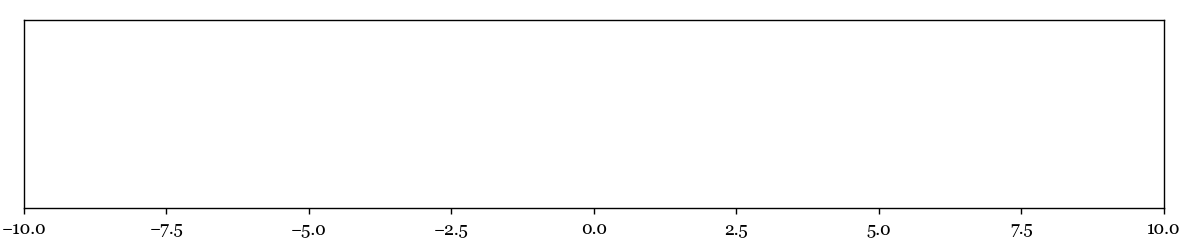

In [100]:
cart_pole = CartPole.CartPole( visual=True, save_frames=False, fig_num=58 )

state = np.array( [ 0, 0, np.pi, 0, 0 ] )
#p = np.array( [0.76187176,  1.19122763, 16.3309897 ,  2.49340076, 0] ) # optimised from theta=0.1
#p = np.array( [0.75971638,  1.44284499, 17.05744679,  2.66183469, 0] ) # optimised from theta=0.5
#p = np.array( [ -0.33143221, -0.42699904, -0.09783966,  0.10055861, 0 ] )
#p = np.array( [2.13646362,  2.594651,   17.62534208,  3.10145759, 0] ) # optimised on model
#p = np.array( [2.29932985, 3.80458197, 22.57529485, 3.9609772, 0] ) # better? optimised on model
#p = np.array( [ 2.42158373, 3.81812947, 22.41281719, 3.95562641, 0 ] ) # optimised on model with 8 second horizon
#p = np.array( [ 2.77273844, 4.15835948, 23.64017977, 4.15351885, 0] ) # optimised on model with larger initial displacement
#p = np.array( [11.91259675, 8.02276575, 29.81324002, 5.60813997, 0] ) # different initial state (bad)
#p = np.array( [1.10893787, 2.01832636, 16.99658894, 2.91580321, 0] ) # fit on noise
#p = np.array([ 0.088,-0.274,-31.37,-4.66,0 ])

cart_pole.set_state( state )

cart_pole._render()

In [102]:
for i in range(50):
    
    noise_level = 0.02

    clipped_state = state
    clipped_state[0] = np.clip( state[0], -2, 2 )
    clipped_state = clipped_state #+ np.random.randn( 5 ) * means * noise_level

    state[4] = p @ clipped_state
    state = CartPole.perform_action_RK4( state )
    cart_pole.set_state( state[:4] )
    cart_pole._render()

In [18]:
p = np.array( [1.10893787, 2.01832636, 16.99658894, 2.91580321, 0] ) # fit on noise
#p = np.array( [ 2.77273844, 4.15835948, 23.64017977, 4.15351885, 0] ) # optimised on model with larger initial displacement

# small oscillations about stable equilibrium

means = np.array([ 2.00951924, 1.964584, 1.98959769, 4.76029465, 0. ])

stable_times = np.ones( 60 ) * 40 * 0.2
noise_levels = np.linspace( 0.01, 0.1, num=60 )

for j, noise_level in enumerate( noise_levels ):
    
    stable_time_sum = 0

    for _ in range(50):
    
        state = np.array( [ 0, 0, 0, 0, 0 ] )
        
        for i in range(400):

            clipped_state = state
            clipped_state[0] = np.clip( state[0], -2, 2 )
            clipped_state = clipped_state + np.random.randn( 5 ) * means * noise_level

            state[4] = p @ clipped_state
            state = CartPole.perform_action_RK4( state )
            
            stable_time_sum += 0.2

            if abs(state[2]) > 2:
                break
                
    stable_times[j] = stable_time_sum

<IPython.core.display.Javascript object>


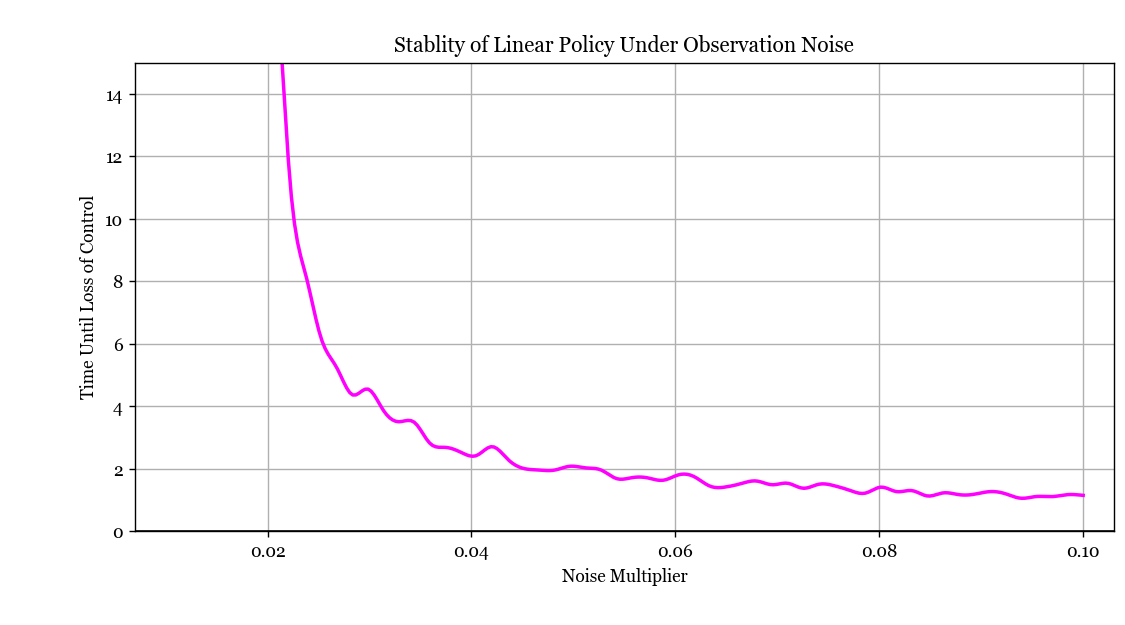

Text(0, 0.5, 'Time Until Loss of Control')

In [45]:
fig, ax = plt.subplots(1, 1, num=18, figsize=(9,5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.12, right=0.99)
sf3utility.setup_phase_portrait( ax )


noise_levels = np.linspace( 0.01, 0.1, num=60 )


interpolant = scipy.interpolate.make_interp_spline( noise_levels, stable_times / 50, bc_type="natural" )

xint = np.linspace( min(noise_levels), max(noise_levels), num=300 )
yint = interpolant( xint )


ax.plot( xint, yint, color="magenta", linewidth=2 )
ax.set_xlim( 0.007, 0.103 )
ax.set_ylim( 0, 15 )

ax.set_title( "Stablity of Linear Policy Under Observation Noise" )
ax.set_xlabel( "Noise Multiplier" )
ax.set_ylabel( "Time Until Loss of Control" )

## Time Until Instability

I reoptimised the linear policy in the presence of observation noise, and then experimented with how long it could keep the pole upright at different noise levels. The plot shows that the new linear policy could maintain control indefinately for low noise levels, but after a certain point the time until loss of control appears to be inversely proportional to the noise level. The new linear policy was not able to control the system over as large a range of initial conditions as the original policy from task 2.3 - I think this is because I optimised it starting from the zero state and so it had experience over a smaller range of states than that policy. The linear policies can only control the system within certain portions of the state space - maybe a nonlinear policy could be capable of doing so over the entire space.